In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.animation import FuncAnimation

import os
import glob
import pandas as pd
import json
from dotenv import load_dotenv
from functools import partial

In [2]:
def get_db(data_dir):
    json_files = glob.glob(os.path.join(data_dir, "*.json"))
    data_list = []

    # Iterate through the JSON files and read them
    for file in json_files:
        with open(file, 'r') as f:
            data = json.load(f)
            data_list.append(data)

    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(data_list)
    return df

In [3]:
model = "bruss"
load_dotenv()
data_dir = os.getenv("DATA_DIR")
output_dir = os.getenv("OUT_DIR")
output_dir = os.path.join(output_dir, model)
os.makedirs(output_dir, exist_ok=True)
df0 = get_db(os.path.join(data_dir, model))
df0['run_id'].unique()

array([nan, 'dist2', 'vary_ab_exp', 'dist', 'vary_a_b', 'vary_sources',
       'vary_du_dv', 'bruss_blowup'], dtype=object)

In [4]:
df = df0.copy()
df = df[(df["run_id"] == 'vary_du_dv') & (df['dt'] == 0.001)]
df

,model,A,B,Nx,dx,Nt,dt,Du,Dv,sigma_ic,random_seed,n_snapshots,filename,sigma_ic_u,sigma_ic_v,run_id,num_sources
69,bruss,5.0,9.0,400,0.5,50000,0.001,2.5,27.5,0.1,1,100,/cluster/scratch/vogtva/data/bruss/55df9fb7-87...,NaN,NaN,vary_du_dv,NaN
113,bruss,5.0,9.0,400,0.5,50000,0.001,2.0,18.0,0.1,1,100,/cluster/scratch/vogtva/data/bruss/5ee1f1b6-2d...,NaN,NaN,vary_du_dv,NaN
119,bruss,5.0,9.0,400,0.5,50000,0.001,1.5,16.5,0.1,1,100,/cluster/scratch/vogtva/data/bruss/55885f1c-0d...,NaN,NaN,vary_du_dv,NaN
158,bruss,5.0,9.0,400,0.5,50000,0.001,1.0,13.0,0.1,1,100,/cluster/scratch/vogtva/data/bruss/e51d7117-bb...,NaN,NaN,vary_du_dv,NaN
256,bruss,5.0,9.0,400,0.5,50000,0.001,2.0,22.0,0.1,1,100,/cluster/scratch/vogtva/data/bruss/d7ac6690-bb...,NaN,NaN,vary_du_dv,NaN
277,bruss,5.0,9.0,400,0.5,50000,0.001,2.0,26.0,0.1,1,100,/cluster/scratch/vogtva/data/bruss/66dbd0ec-65...,NaN,NaN,vary_du_dv,NaN
373,bruss,5.0,9.0,400,0.5,50000,0.001,2.5,32.5,0.1,1,100,/cluster/scratch/vogtva/data/bruss/087d1e53-27...,NaN,NaN,vary_du_dv,NaN
512,bruss,5.0,9.0,400,0.5,50000,0.001,1.0,7.0,0.1,1,100,/cluster/scratch/vogtva/data/bruss/6237fca6-5e...,NaN,NaN,vary_du_dv,NaN
695,bruss,5.0,9.0,400,0.5,50000,0.001,2.5,17.5,0.1,1,100,/cluster/scratch/vogtva/data/bruss/e6d04a30-de...,NaN,NaN,vary_du_dv,NaN
697,bruss,5.0,9.0,400,0.5,50000,0.001,2.0,14.0,0.1,1,100,/cluster/scratch/vogtva/data/bruss/457afbc2-6e...,NaN,NaN,vary_du_dv,NaN


In [5]:
def ab_grid(
    df, component_idx=0, frame=-1, sigdigits=2, var1="A", var2="B", file="", an=False
):
    if len(df) == 0:
        return None

    df = df.sort_values(by=[var1, var2])
    A_count = len(df[var1].unique())
    print(A_count)
    B_count = int(len(df) / A_count)
    print(B_count)
    fig = plt.figure(figsize=(5 * B_count + 1, 3 * A_count))
    grid = ImageGrid(fig, 111, nrows_ncols=(A_count, B_count), axes_pad=(0.1, 0.3))

    ims = []

    for i, row in df.iterrows():
        ds = nc.Dataset(row["filename"])

        data = ds.variables["data"][:]
        ims.append((row, data[0, frame, :, component_idx::2]))

    for ax, (row, im) in zip(grid, ims):
        ax.set_title(
            f"{var1}={row[var1]:.{sigdigits}f}\n{var2} = {row[var2]:.{sigdigits}f}",
            fontsize=6,
        )
        ax.imshow(im, cmap="viridis")
        ax.set_aspect("equal")
        ax.axis("off")
    row = df.iloc[0]
    if frame == -1:
        time = row["dt"] * row["Nt"]
    else:
        time = row["dt"] * frame * row["Nt"] / row["n_snapshots"]
    fig.suptitle(
        f"{row['model'].capitalize()}, Nx={row['Nx']}, dx={row['dx']}, dt={row['dt']}, T={time:.2f}",
        fontsize=16,
    )

    if file != "":
        plt.savefig(file, dpi=100)
    if not an:
        plt.show()
    return grid


1
16


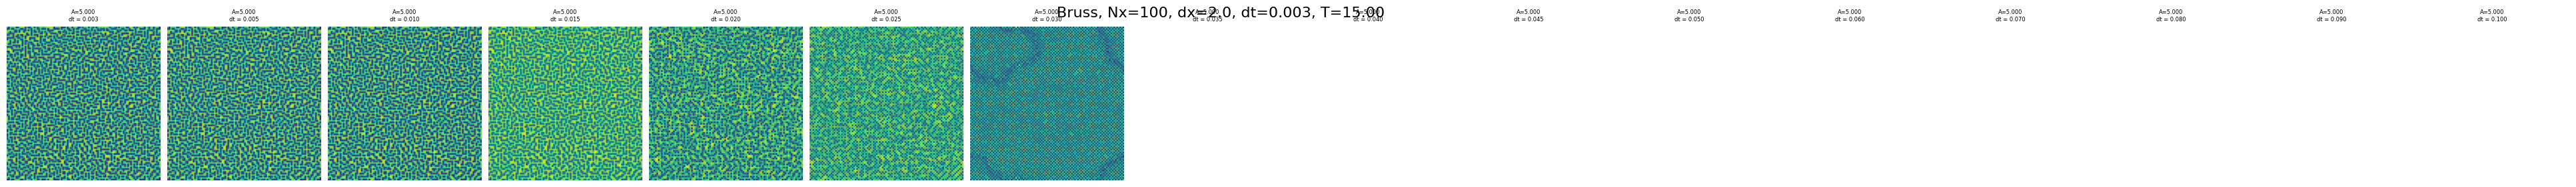

In [17]:
ab_grid(df, 1, frame=-1, sigdigits=3, var1="A", var2="dt")#, file="gray_scott_ab")

In [12]:
def convergence_plot(df, sigdigits=2, var1="A", var2="B", file=""):
    if len(df) == 0:
        return None

    df = df.sort_values(by=[var1, var2])
    df = df.reset_index(drop=True)
    A_count = len(df[var1].unique())
    B_count = int(len(df) / A_count)

    fig, axes = plt.subplots(A_count, B_count, figsize=(3 * B_count + 1, 5 * A_count))
    axes = np.atleast_2d(axes)
    for i, row in df.iterrows():
        ds = nc.Dataset(row["filename"])
        data = ds.variables["data"][:]
        steady_state = np.zeros_like(data[0, 0, :, :])
        steady_state[:, 0::2] = row["A"]
        steady_state[:, 1::2] = row["B"]
        l1 = []
        for j in range(data.shape[1]):
            l1.append(np.linalg.norm(data[0, j, :, :] - steady_state, 1) / np.prod(data.shape[2:]))

        axes[i // B_count, i % B_count].plot(
            np.arange(0, data.shape[1]) * row["dt"] * row["Nt"] / row["n_snapshots"],
            l1,
        )
        axes[i // B_count, i % B_count].set_title(
            f"{var1}={row[var1]:.{sigdigits}f}\n{var2} = {row[var2]:.{sigdigits}f}",
            fontsize=6,
        )
        # axes[i // B_count, i % B_count].axis("off")
    row = df.iloc[0]
    time = row["dt"] * row["Nt"]
    fig.suptitle(
        f"{row['model'].capitalize()}, Nx={row['Nx']}, dx={row['dx']}, dt={row['dt']}, T={time:.2f}",
        fontsize=16,
    )
    plt.tight_layout()
    plt.show()
    if file != "":
        fig.savefig(file, dpi=100)


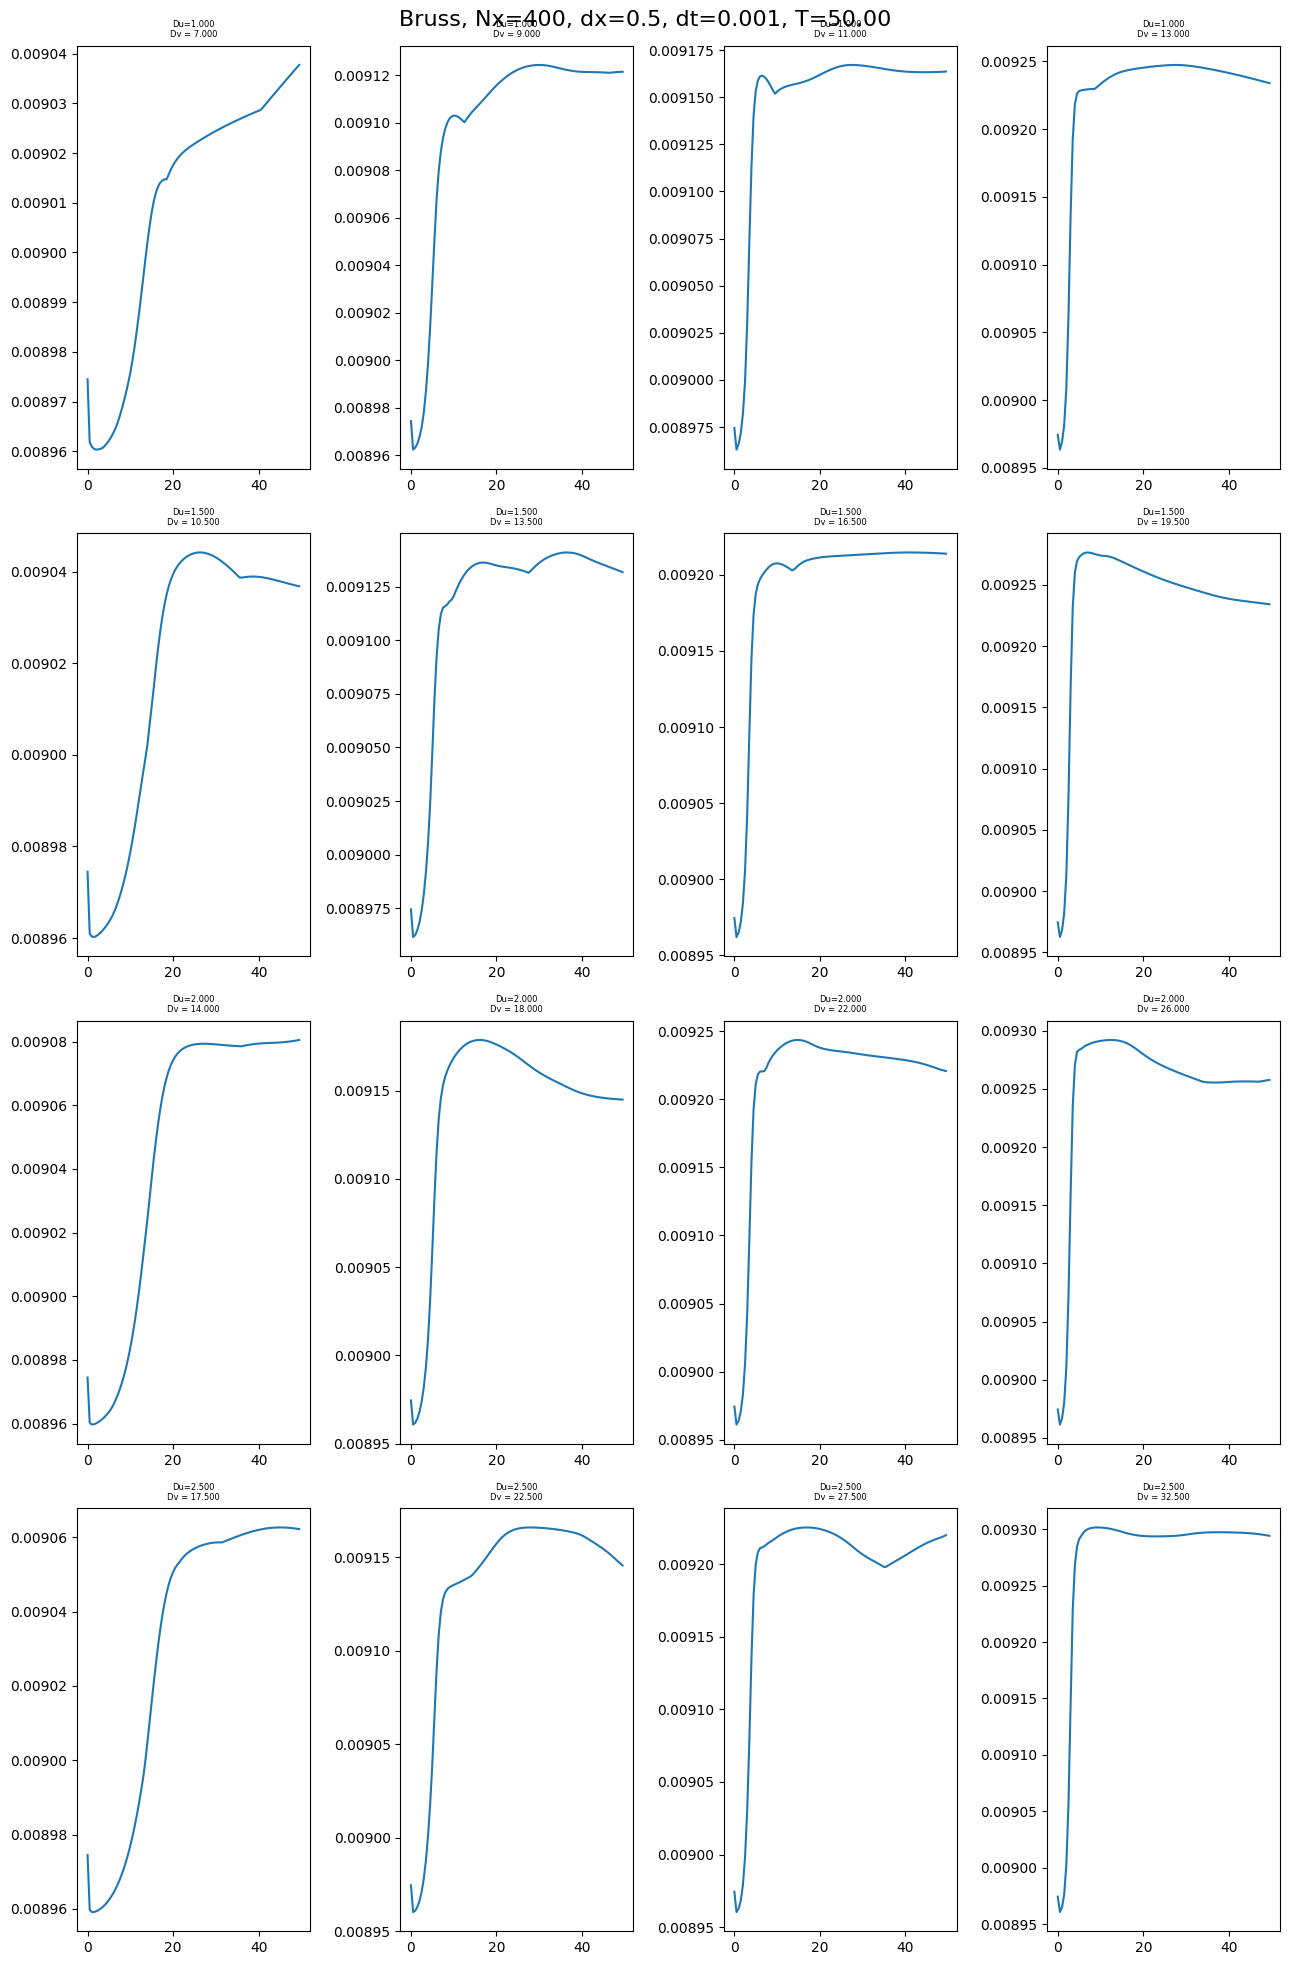

In [14]:
convergence_plot(df, sigdigits=2, var1="Du", var2="Dv", file="du_dv_convergence")